In [17]:
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
import requests
from bs4 import BeautifulSoup
import re
import geopy # https://github.com/shakasom/geocoding/blob/master/geocoding.ipynb
from geopy.geocoders import Nominatim
import json
import geopy.distance
import numpy as np
import itertools
import shapely.geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import tabula
import datetime as dt
import missingno as msno
import seaborn as sns
import matplotlib as mpl
import os
import copy

In [402]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System (PCS): how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System (GCS): how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import historical apartment lease rates across Toronto from TRREB
- TRREB = Toronto Regional Real Estate Board
- aggregated level = MLB districts
- latest report: https://trreb.ca/index.php/market-news/rental-market-report

In [5]:
year= 2022
quarter = 4
r = requests.get(f"https://trreb.ca/files/market-stats/rental-reports/rental_report_Q{quarter}-{year}.pdf")

In [6]:
r.status_code == 404

False

## PDF version (unstable but fast)

### download

In [24]:
# data before 2012 are in a different format
start_year = 2012
start_quarter = 1
year = start_year
quarter = start_quarter

while True:
    if f'Q{quarter}-{year}.pdf' in os.listdir('../data/raw/rent/'):
        # if file already downloaded, do nothing
        print(f"Q{quarter}-{year} already downloaded")
        if quarter == 4:
            year += 1
            quarter = 1
        else:
            quarter += 1
    else:
        # download file
        response = requests.get(f"https://trreb.ca/files/market-stats/rental-reports/rental_report_Q{quarter}-{year}.pdf")
        # if file is published, download it
        if response.status_code == 200:
            with open(f'../data/raw/rent/Q{quarter}-{year}.pdf', 'wb') as f:
                f.write(response.content)
            print(f"Downloaded Q{quarter}-{year}")
            if quarter == 4:
                year += 1
                quarter = 1
            else:
                quarter += 1    
        # if file is not published yet, stop
        else:
            break

if quarter == 1:
    end_year = year - 1
else:
    end_year = year

Q1-2012 already downloaded
Q2-2012 already downloaded
Q3-2012 already downloaded
Q4-2012 already downloaded
Q1-2013 already downloaded
Q2-2013 already downloaded
Q3-2013 already downloaded
Q4-2013 already downloaded
Q1-2014 already downloaded
Q2-2014 already downloaded
Q3-2014 already downloaded
Q4-2014 already downloaded
Q1-2015 already downloaded
Q2-2015 already downloaded
Q3-2015 already downloaded
Q4-2015 already downloaded
Q1-2016 already downloaded
Q2-2016 already downloaded
Q3-2016 already downloaded
Q4-2016 already downloaded
Q1-2017 already downloaded
Q2-2017 already downloaded
Q3-2017 already downloaded
Q4-2017 already downloaded
Q1-2018 already downloaded
Q2-2018 already downloaded
Q3-2018 already downloaded
Q4-2018 already downloaded
Q1-2019 already downloaded
Q2-2019 already downloaded
Q3-2019 already downloaded
Q4-2019 already downloaded
Q1-2020 already downloaded
Q2-2020 already downloaded
Q3-2020 already downloaded
Q4-2020 already downloaded
Q1-2021 already downloaded
Q

### tabula
- other options: camelot
- unstable extraction

In [18]:
years = [*range(start_year,end_year + 1,1)]
quarters = [*range(1,5,1)]
dfs = []
trreb_dfs = []
for year in years:
    for quarter in quarters:
        try:
            file1 = f'../data/raw/rent/Q{quarter}-{year}.pdf'
            # focus: apartment
            # we take the table on 3rd page = apartment rental transactions in City of Toronto
            # there are also tables on other pages, 
            # e.g. 5th page = townhouse rental transactions in City of Toronto
            table = tabula.read_pdf(file1, pages = '3', stream=True, area = (68.52,13.39,566.463,829.348))[0]
            table.drop(table.index[0:(np.where(table.iloc[:,0] == 'Toronto West')[0][0]-2)], inplace=True)
            table.dropna(axis=1, how='all', inplace=True)
            table.set_index(table.columns[0], inplace=True)
            splits = [table[col].str.split(pat=' ', expand=True).add_prefix(col) for col in table.columns]
            table = pd.concat(splits, axis=1)
            table = table.reset_index(drop=False)
            col1 = ['district'] + [x for x in ['AllApartments', 'Bachelor', 'OneBedroom', 'TwoBedroom', 'ThreeBedroom'] for _ in (0, 1)]
            col2 = ["", "Listed", "Leased"] + ["TotalLeased", "AvgLeaseRate"]*4
            table.columns = ['_'.join([x,y]).strip('_') for x, y in zip(col2,col1)]
            
            # save trreb total row
            trreb_table = copy.deepcopy(table.iloc[0:1,:])
            trreb_table.iloc[:,1:] = trreb_table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
            trreb_table['Year'] = year
            trreb_table['Quarter'] = quarter
            trreb_table.replace(0, np.nan, inplace=True)
            trreb_dfs.append(trreb_table)
            
            table = table.loc[table['district'].apply(lambda x: re.search('\d+', x) is not None)]
            table['district'] = table['district'].apply(lambda x: re.search('\w\d{2}', x).group())
            table.iloc[:,1:] = table.iloc[:,1:].apply(lambda x_row: pd.Series([int(''.join(re.findall('\d+', x))) if re.findall('\d+', x) != [] else np.nan for x in x_row.values]), axis = 1).values
            table['Year'] = year
            table['Quarter'] = quarter
            # 0 means there are no transactions, so we replace it with NaN
            table.replace(0, np.nan, inplace=True)
            table.reset_index(drop=True, inplace=True)
        except FileNotFoundError:
            table = None
        except ValueError:
            print(f"Q{quarter}-{year} error")
        dfs.append(table)

Got stderr: Apr. 19, 2023 12:47:09 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr. 19, 2023 12:47:09 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Apr. 19, 2023 12:47:11 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr. 19, 2023 12:47:11 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Apr. 19, 2023 12:47:13 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr. 19, 2023 12:47:13 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Apr. 19, 2023 12:47:15 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr. 19, 2023 12:47:15 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Apr. 19, 2023 12:47:17 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr. 19, 2023 12:47:17 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: Apr. 19, 2023 12:47:19 P.M. org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Apr. 19, 2023 12:47:19 P.M. org.

Q3-2022 error
Q4-2022 error


## Excel version (stable but slow)
- need Adobe Pro to convert PDF to Excel (chrome extension)

In [329]:
# data before 2012 are in a different format
start_year = 2012
start_quarter = 1
year = start_year
quarter = start_quarter

while True:
    if f'rental_report_Q{quarter}-{year}.xlsx' in os.listdir('../data/raw/rent/'):
        # if file already downloaded, do nothing
        print(f"Q{quarter}-{year} already downloaded")
        if quarter == 4:
            year += 1
            quarter = 1
        else:
            quarter += 1
    else:
        # download manually
        print(f"Q{quarter}-{year} not downloaded")
        break

if quarter == 1:
    end_year = year - 1
else:
    end_year = year

# print end year and quarter
print(f"End year: {end_year}")


Q1-2012 already downloaded
Q2-2012 already downloaded
Q3-2012 already downloaded
Q4-2012 already downloaded
Q1-2013 already downloaded
Q2-2013 already downloaded
Q3-2013 already downloaded
Q4-2013 already downloaded
Q1-2014 already downloaded
Q2-2014 already downloaded
Q3-2014 already downloaded
Q4-2014 already downloaded
Q1-2015 already downloaded
Q2-2015 already downloaded
Q3-2015 already downloaded
Q4-2015 already downloaded
Q1-2016 already downloaded
Q2-2016 already downloaded
Q3-2016 already downloaded
Q4-2016 already downloaded
Q1-2017 already downloaded
Q2-2017 already downloaded
Q3-2017 already downloaded
Q4-2017 already downloaded
Q1-2018 already downloaded
Q2-2018 already downloaded
Q3-2018 already downloaded
Q4-2018 already downloaded
Q1-2019 already downloaded
Q2-2019 already downloaded
Q3-2019 already downloaded
Q4-2019 already downloaded
Q1-2020 already downloaded
Q2-2020 already downloaded
Q3-2020 already downloaded
Q4-2020 already downloaded
Q1-2021 already downloaded
Q

In [492]:
years = [*range(start_year,end_year + 1,1)]
quarters = [*range(1,5,1)]
dfs = []
for year in years:
    for quarter in quarters:
        try:
            table = pd.read_excel(f'../data/raw/rent/rental_report_Q{quarter}-{year}.xlsx', sheet_name='Table 1', na_values=['-','‐'])
            start_index = table[table.iloc[:,0] == 'Toronto W01'].index[0]
            end_index = table[table.iloc[:,0] == 'Toronto E11'].index[0]
            table.columns = table.iloc[start_index-5, :]

            table = table.iloc[(start_index):(end_index+1), :]

            table = table.loc[:,table.notnull().sum() != 0].reset_index(drop=True)
            # if \n is in the cell, split it and copy down one cell
            for i in range(table.shape[0]):
                for j in range(table.shape[1]):
                    if '\n' in str(table.iloc[i,j]):
                        try:
                            # replace next row only if it is empty
                            if table.iloc[i+1,j] is np.nan:
                                table.iloc[i:(i+2),j] = str(table.iloc[i,j]).split('\n')
                            else:
                                # throw error if the next cell is not empty
                                raise ValueError(f'{i,j} Next cell is not empty')
                        except:
                            print(f'Cell {i,j} Error')
            table.columns = ['district', 'Listed_AllApartments', 'Leased_AllApartments', 'TotalLeased_Bachelor', 'AvgLeaseRate_Bachelor', 'TotalLeased_OneBedroom', 'AvgLeaseRate_OneBedroom', 'TotalLeased_TwoBedroom', 'AvgLeaseRate_TwoBedroom', 'TotalLeased_ThreeBedroom', 'AvgLeaseRate_ThreeBedroom']
            # remove 'Toronto ' from district name
            table['district'] = table['district'].str.replace('Toronto ', '')
            table['Year'] = year
            table['Quarter'] = quarter
            # 0 means there are no transactions, so we replace it with NaN
            table.replace(0, np.nan, inplace=True)

            # remove aggregated levels such as Central, West and East
            table = table[table['district'].apply(lambda x: re.search('\d+', x) is not None)]
            table.set_index('district', inplace=True)

            table = table.astype('Int64')
        except FileNotFoundError:
            table = None
            print(f"Q{quarter}-{year} not downloaded")
            
        except:
            print(f"Q{quarter}-{year} error")
            
        dfs.append(table)

In [497]:
rent = pd.concat(dfs, axis=0).reset_index(drop=False)
rent

district  Listed_AllApartments  Leased_AllApartments   
0         W01                    66                    32  \
1         W02                    13                     9   
2         W03                     3                     3   
3         W04                    10                     2   
4         W05                    43                    17   
...       ...                   ...                   ...   
1535      E07                   116                    78   
1536      E08                    28                    14   
1537      E09                   208                   152   
1538      E10                    21                     9   
1539      E11                    23                    18   

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom   
0                     <NA>                   <NA>                      24  \
1                     <NA>                   <NA>                       3   
2                     <NA>                   <NA>                       2   
3                     <NA>                   <NA>                       1   
4                     <NA>                   <NA>                      12   
...                    ...                    ...                     ...   
1535                  <NA>                   <NA>                      40   
1536                  <NA>                   <NA>                       5   
1537                     6                   2093                      89   
1538                  <NA>                   <NA>                       5   
1539                  <NA>                   <NA>                       9   

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom   
0                        1539                       8  \
1                        1633                       6   
2                        1050                       1   
3                        1150                       1   
4                        1354                       5   
...                       ...                     ...   
1535                     2305                      35   
1536                     2129                       8   
1537                     2419                      54   
1538                     2150                       3   
1539                     2139                       7   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom   
0                        2031                      <NA>  \
1                        1679                      <NA>   
2                        1650                      <NA>   
3                        1350                      <NA>   
4                        1578                      <NA>   
...                       ...                       ...   
1535                     2663                         3   
1536                     2654                         1   
1537                     2881                         3   
1538                     2500                         1   
1539                     2546                         2   

      AvgLeaseRate_ThreeBedroom  Year  Quarter  
0                          <NA>  2012        1  
1                          <NA>  2012        1  
2                          <NA>  2012        1  
3                          <NA>  2012        1  
4                          <NA>  2012        1  
...                         ...   ...      ...  
1535                       2817  2022        4  
1536                       2700  2022        4  
1537                       3483  2022        4  
1538                       2950  2022        4  
1539                       2950  2022        4  

[1540 rows x 13 columns]

In [498]:
rent['YearQuarter'] = rent['Year'].astype(str) + 'Q' + rent['Quarter'].astype(str)

In [499]:
rent.sort_values(by=['district', 'YearQuarter'], inplace=True)
rent.reset_index(drop=True, inplace=True)

In [500]:
rent.describe()

Listed_AllApartments  Leased_AllApartments  TotalLeased_Bachelor   
count                1533.0                1519.0                 641.0  \
mean             333.526419            188.943384             19.950078   
std              921.366662            492.651405              49.25099   
min                     1.0                   1.0                   1.0   
25%                    29.0                  15.0                   1.0   
50%                    72.0                  42.0                   3.0   
75%                   232.0                 129.5                   9.0   
max                 12795.0                4968.0                 354.0   

       AvgLeaseRate_Bachelor  TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom   
count                  641.0                  1467.0                   1467.0  \
mean             1504.435257              116.347648              1784.545331   
std               269.385178              313.177225               345.615669   
min                    175.0                     1.0                    850.0   
25%                   1327.0                     7.5                   1511.0   
50%                   1500.0                    23.0                   1791.0   
75%                   1692.0                    78.5                   2021.0   
max                   2758.0                  3101.0                   2932.0   

       TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom   
count                  1484.0                   1484.0  \
mean                65.345013              2366.803908   
std                144.574907               624.851684   
min                       1.0                   1075.0   
25%                       7.0                  1933.75   
50%                      18.0                   2321.5   
75%                      55.0                   2710.5   
max                    1391.0                   5900.0   

       TotalLeased_ThreeBedroom  AvgLeaseRate_ThreeBedroom      Year   Quarter  
count                    1042.0                     1042.0    1540.0    1540.0  
mean                   6.298464                3022.538388    2017.0       2.5  
std                    13.69414                1439.452831  3.163305  1.118397  
min                         1.0                      575.0    2012.0       1.0  
25%                         1.0                     2125.0    2014.0      1.75  
50%                         3.0                     2700.0    2017.0       2.5  
75%                         5.0                     3503.0    2020.0      3.25  
max                       169.0                    17440.0    2022.0       4.0

# Plot lease demand

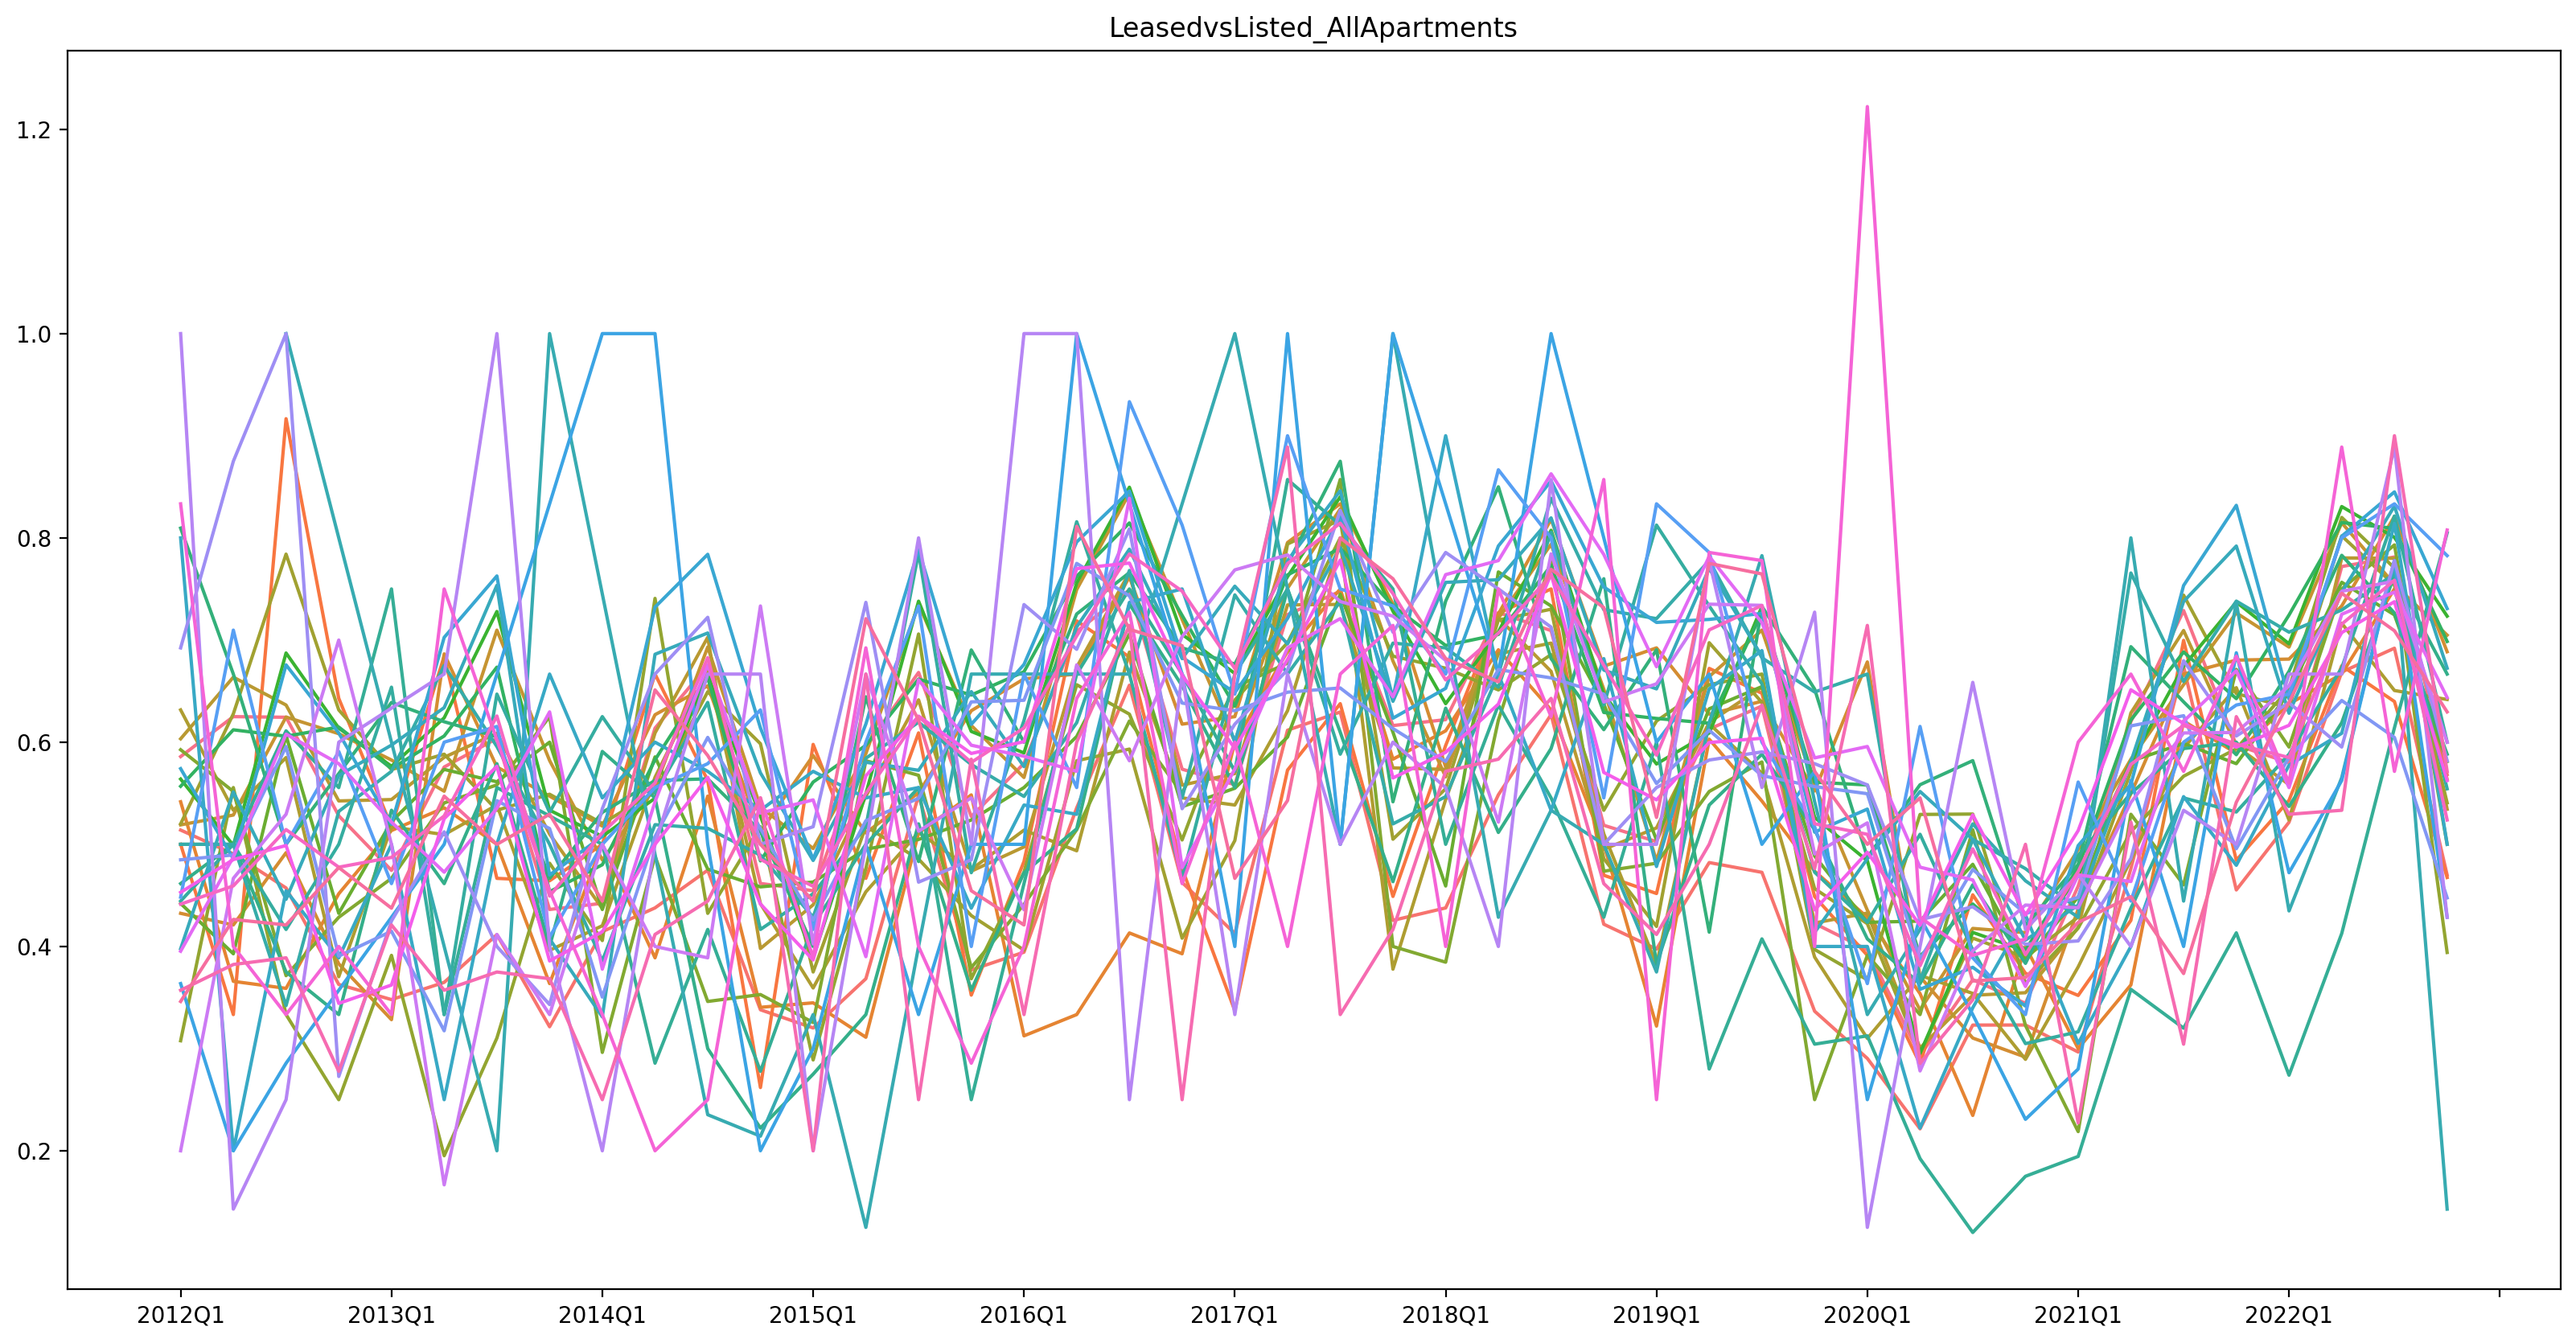

In [501]:
rent['LeasedvsListed_AllApartments'] = rent['Leased_AllApartments'] / rent['Listed_AllApartments']
ax = sns.lineplot(x='YearQuarter', y='LeasedvsListed_AllApartments', data=rent, hue='district', legend=False)
ax.title.set_text('LeasedvsListed_AllApartments')
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))

In [502]:
# number of leased units / number of listing cannot be > 1
rent[['district', 'LeasedvsListed_AllApartments']].sort_values(by='LeasedvsListed_AllApartments', ascending=False).head(5)

district  LeasedvsListed_AllApartments
1396      W07                      1.222222
1188      W03                           1.0
1020      E10                           1.0
1021      E10                           1.0
1029      E10                           1.0

In [503]:
# identify the problematic record 
location = rent['LeasedvsListed_AllApartments'].argmax()
rent.loc[location:location,]

district  Listed_AllApartments  Leased_AllApartments   
1396      W07                     9                    11  \

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom   
1396                  <NA>                   <NA>                       5  \

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom   
1396                     2010                       6  \

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom   
1396                     2900                      <NA>  \

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter   
1396                       <NA>  2020        1      2020Q1  \

      LeasedvsListed_AllApartments  
1396                      1.222222

In [504]:
# fix the number of listing = number of leased
rent.loc[location:location, 'Listed_AllApartments'] = rent.loc[location:location, 'Leased_AllApartments']
rent.loc[location:location, 'LeasedvsListed_AllApartments'] = 1
rent.loc[location:location,]

district  Listed_AllApartments  Leased_AllApartments   
1396      W07                    11                    11  \

      TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom   
1396                  <NA>                   <NA>                       5  \

      AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom   
1396                     2010                       6  \

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom   
1396                     2900                      <NA>  \

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter   
1396                       <NA>  2020        1      2020Q1  \

      LeasedvsListed_AllApartments  
1396                           1.0

# Plot lease counts and rates

In [505]:
rent.columns

Index(['district', 'Listed_AllApartments', 'Leased_AllApartments',
       'TotalLeased_Bachelor', 'AvgLeaseRate_Bachelor',
       'TotalLeased_OneBedroom', 'AvgLeaseRate_OneBedroom',
       'TotalLeased_TwoBedroom', 'AvgLeaseRate_TwoBedroom',
       'TotalLeased_ThreeBedroom', 'AvgLeaseRate_ThreeBedroom', 'Year',
       'Quarter', 'YearQuarter', 'LeasedvsListed_AllApartments'],
      dtype='object')

In [506]:
lease_rates = [re.search('AvgLeaseRate_\w+', x).group(0) for x in rent.columns if re.search('AvgLeaseRate_\w+', x) is not None]
lease_count = [re.search('TotalLeased_\w+', x).group(0) for x in rent.columns if re.search('TotalLeased_\w+', x) is not None]

Text(0.5, 0.98, 'Summer cyclical pattern in number of leased apartments by district')

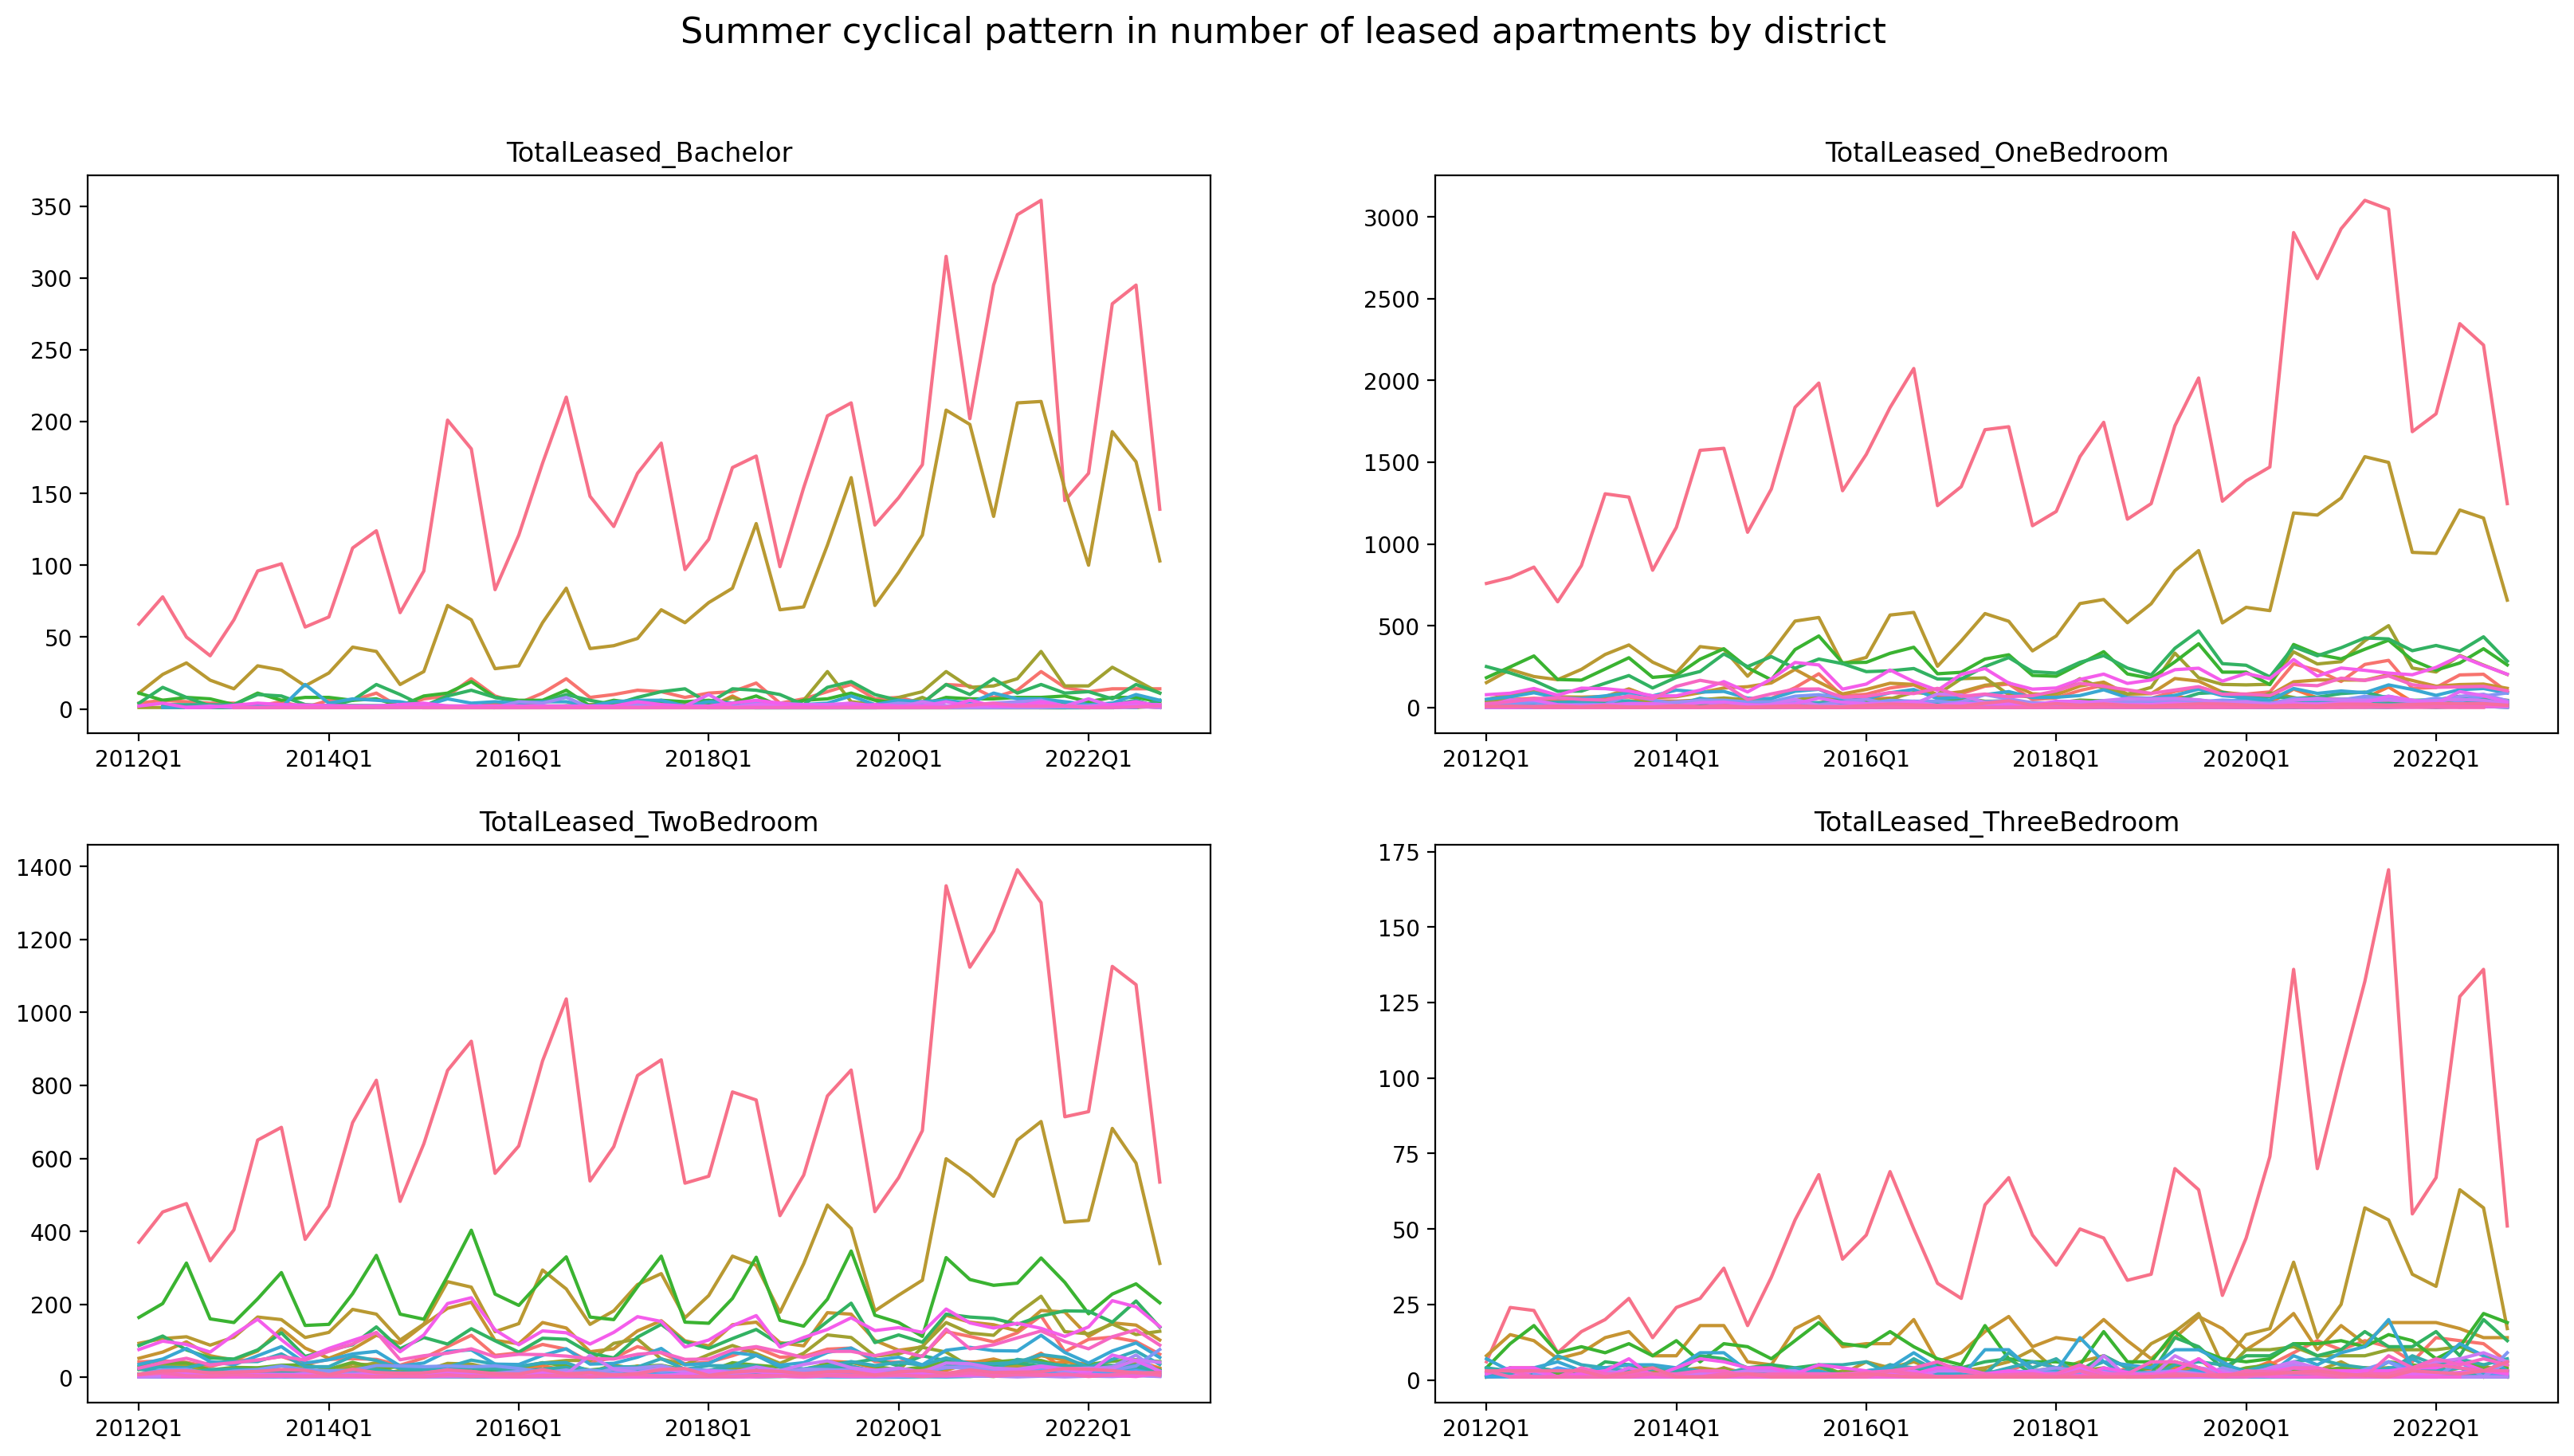

In [507]:
# plotting number of leased apartments by district
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

plt.suptitle('Summer cyclical pattern in number of leased apartments by district', fontsize=16)

In [508]:
# As expexted, C08 and C01 are the districts closest to downtown
print(f"Top 5 districts by number of leased apartments as of {rent['YearQuarter'].max()}:")
rent[rent['YearQuarter'] == rent['YearQuarter'].max()].groupby('district').TotalLeased_Bachelor.mean().sort_values(ascending=False).head()

Top 5 districts by number of leased apartments as of 2022Q4:


district
C01    139.0
C08    103.0
C02     14.0
C10     11.0
C15     11.0
Name: TotalLeased_Bachelor, dtype: Float64

Text(0.5, 0.98, 'Excluding C08 and C01')

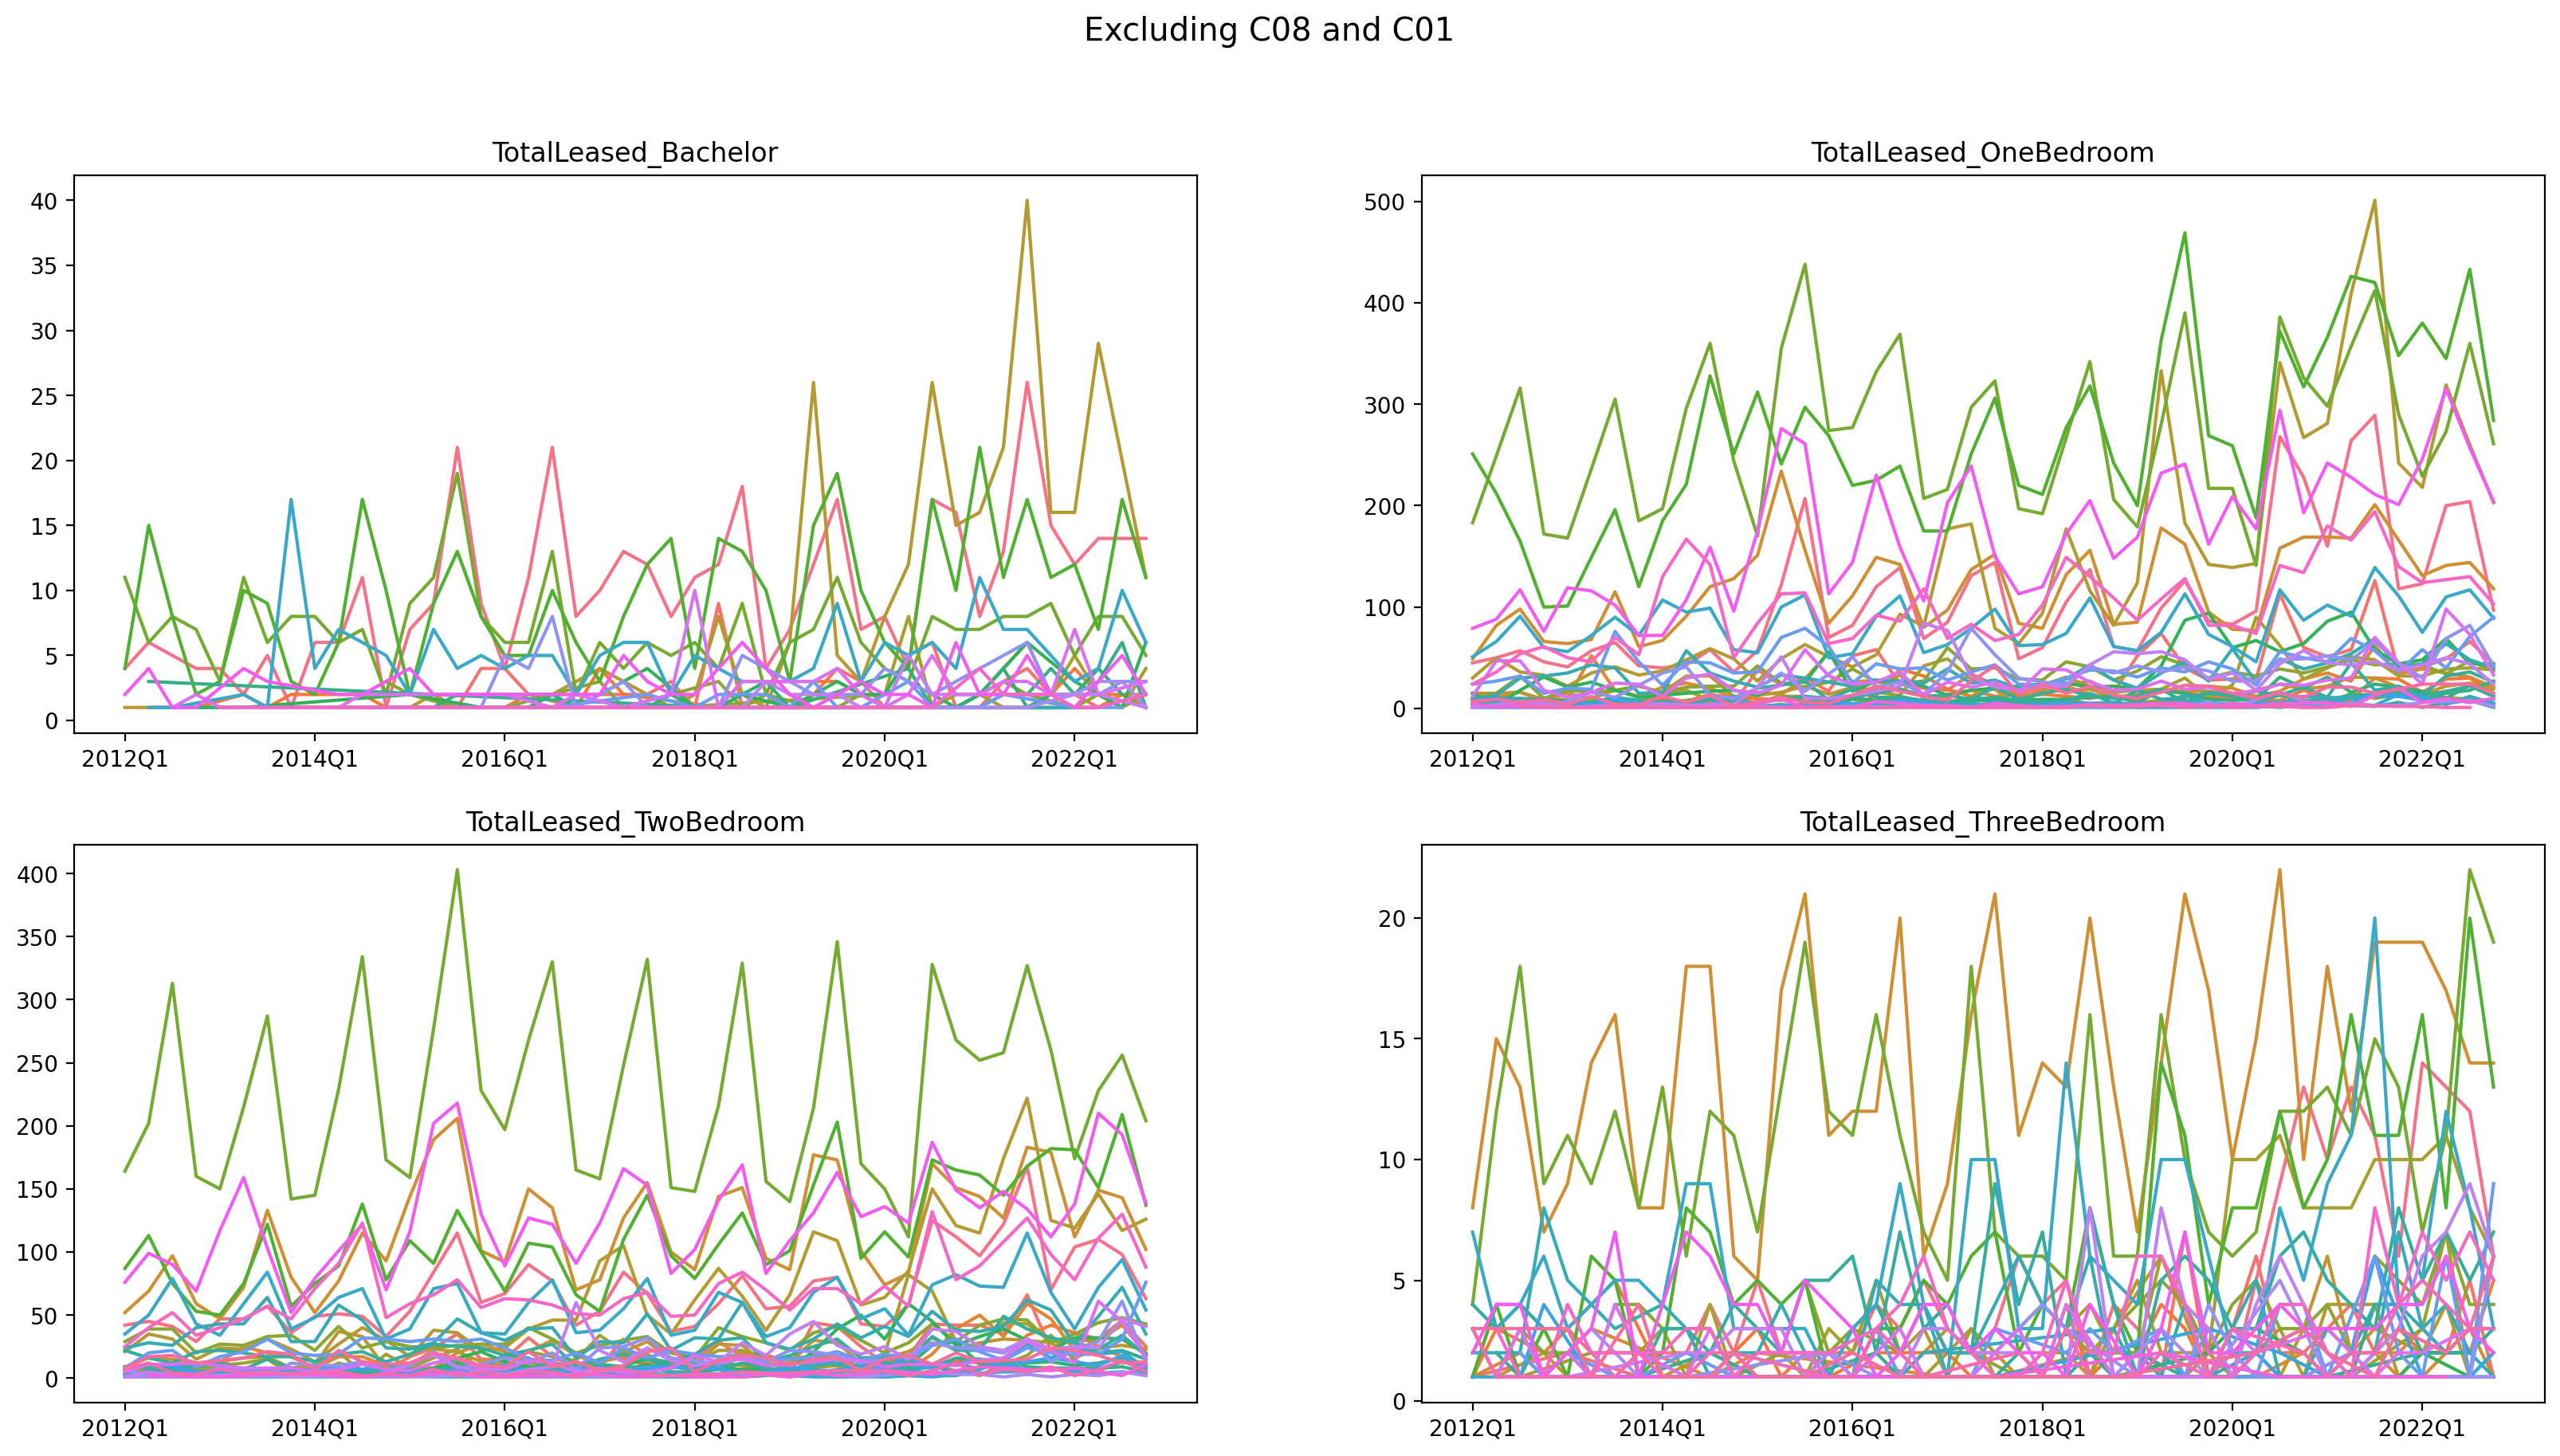

In [509]:
# Exclude the top 2 districts
fig, axes = plt.subplots(int(len(lease_count)/2),2)
for col, ax in zip(lease_count, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent[~(rent['district'].isin(['C08', 'C01']))], hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))
fig.suptitle('Excluding C08 and C01', size = 'x-large')

# Fix average lease rate

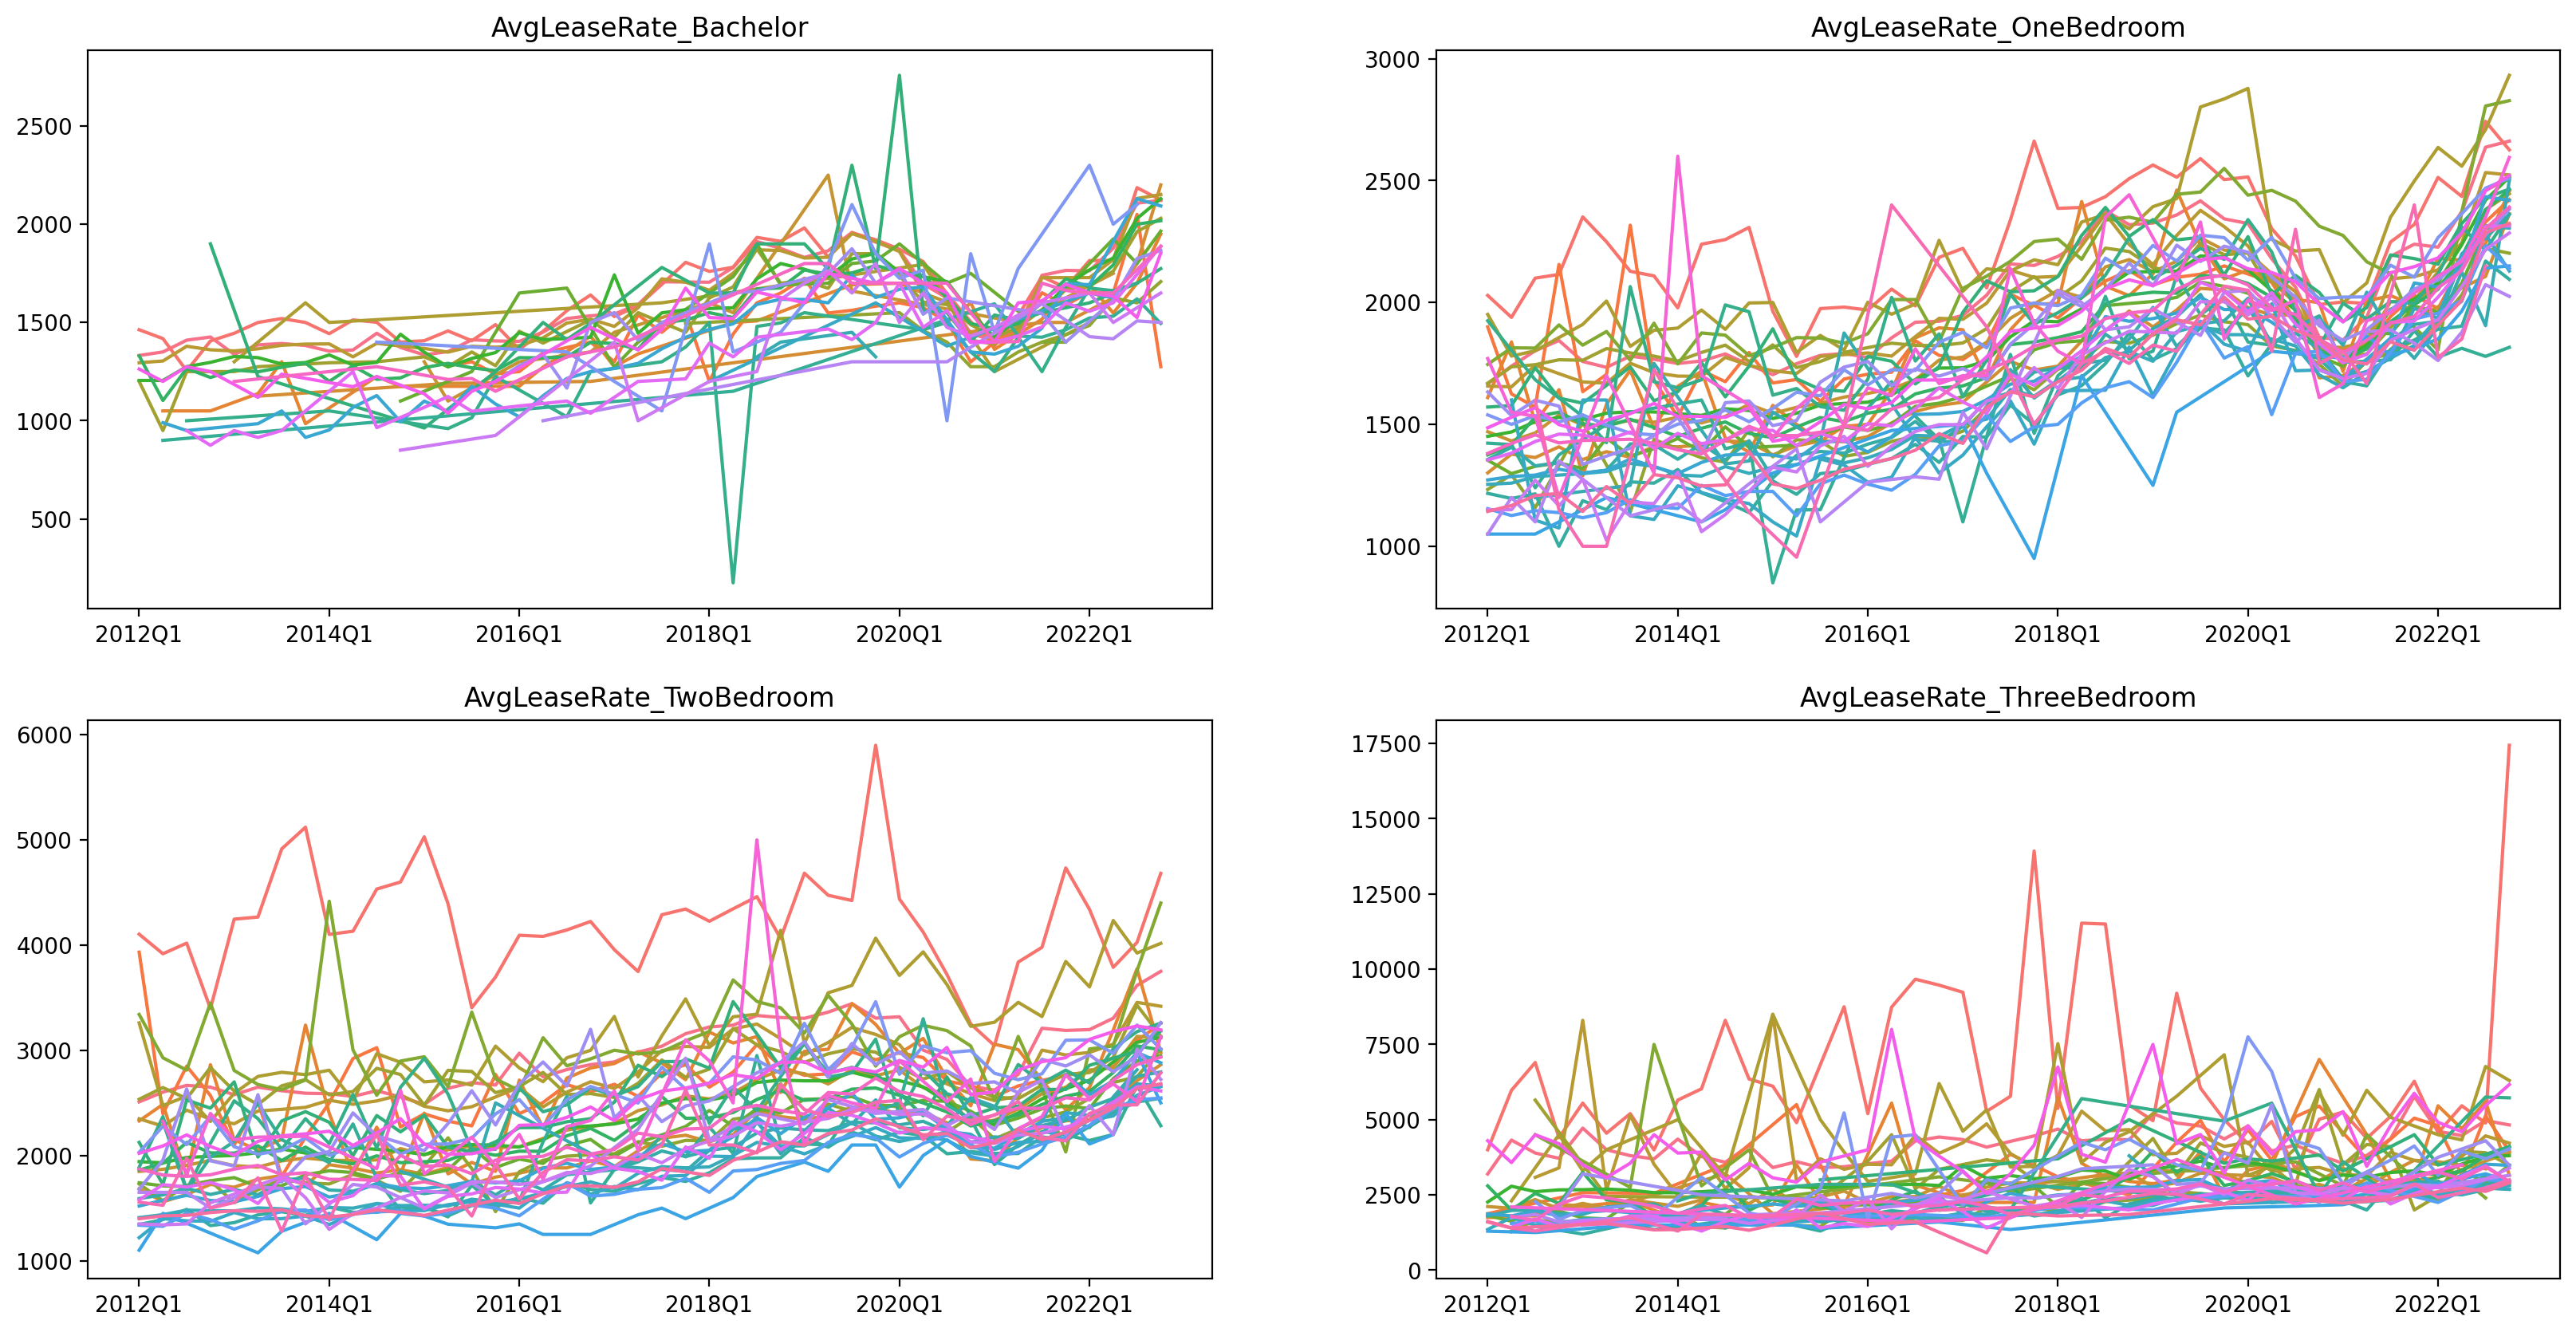

In [510]:
# plotting average lease rates of apartments by district
fig, axes = plt.subplots(int(len(lease_rates)/2),2)
for col, ax in zip(lease_rates, axes.flatten()):
    sns.lineplot(x='YearQuarter', y=col, data=rent, hue='district', legend=False, ax=ax)
    ax.title.set_text(col)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))

In [511]:
# the most expensive district for one bedroom is C09
rent.loc[rent['AvgLeaseRate_OneBedroom'].argmax():rent['AvgLeaseRate_OneBedroom'].argmax(),]

district  Listed_AllApartments  Leased_AllApartments   
351      C09                    67                    43  \

     TotalLeased_Bachelor  AvgLeaseRate_Bachelor  TotalLeased_OneBedroom   
351                  <NA>                   <NA>                      19  \

     AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom  AvgLeaseRate_TwoBedroom   
351                     2932                      23                     4017  \

     TotalLeased_ThreeBedroom  AvgLeaseRate_ThreeBedroom  Year  Quarter   
351                         1                       6300  2022        4  \

    YearQuarter  LeasedvsListed_AllApartments  
351      2022Q4                      0.641791

In [512]:
# the suddent dip in 2018 in lease rate of bachelor apartments may not make sense
location = rent['AvgLeaseRate_Bachelor'].argmin()
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_Bachelor', 'YearQuarter']]

district  AvgLeaseRate_Bachelor YearQuarter
684      E02                   1500      2018Q1
685      E02                    175      2018Q2
686      E02                   1480      2018Q3

In [513]:
# $175 per month for a bachelor does not make sense
# could be manual error for missing a zero in input
# let's remove the weird data point
rent.loc[location, 'AvgLeaseRate_Bachelor'] = np.nan
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_Bachelor', 'YearQuarter']]

district  AvgLeaseRate_Bachelor YearQuarter
684      E02                   1500      2018Q1
685      E02                   <NA>      2018Q2
686      E02                   1480      2018Q3

In [514]:
# the suddent spike in 2022 in lease rate of 3 bedroom apartments may not make sense
location = rent['AvgLeaseRate_ThreeBedroom'].argmax()
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_ThreeBedroom', 'YearQuarter']]

district  AvgLeaseRate_ThreeBedroom YearQuarter
86      C02                       4889      2022Q3
87      C02                      17440      2022Q4
88      C03                       1875      2012Q1

In [515]:
# $17440 per month for a bachelor may not make sense
# could be outlier
# let's remove the weird data point
rent.loc[location, 'AvgLeaseRate_ThreeBedroom'] = np.nan
rent.loc[(location-1):(location+1),['district', 'AvgLeaseRate_ThreeBedroom', 'YearQuarter']]

district  AvgLeaseRate_ThreeBedroom YearQuarter
86      C02                       4889      2022Q3
87      C02                       <NA>      2022Q4
88      C03                       1875      2012Q1

# TRREB total stats

In [516]:
# # TRREB total = aggregate statistics across all districts in TRREB
# trreb_total = pd.concat(trreb_dfs, axis=0)
# trreb_total.reset_index(drop=True, inplace=True)
# trreb_total['YearQuarter'] = trreb_total['Year'].astype(str) + 'Q' + trreb_total['Quarter'].astype(str)
# trreb_total.sort_values(by=['YearQuarter'], inplace=True)
# trreb_total['district'] = 'TRREB total'
# trreb_total

In [517]:
# # plotting average lease rates of apartments across all districts
# fig, axes = plt.subplots(int(len(lease_rates)/2),2)
# for col, ax in zip(lease_rates, axes.flatten()):
#     sns.lineplot(x='YearQuarter', y=col, data=trreb_total, hue='district', legend=True, ax=ax)
#     ax.title.set_text(col)
#     ax.yaxis.label.set_visible(False)
#     ax.xaxis.label.set_visible(False)
#     ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(8))
# fig.suptitle('Average lease rates across all Toronto districts', size = 'x-large')

# Check missing data

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

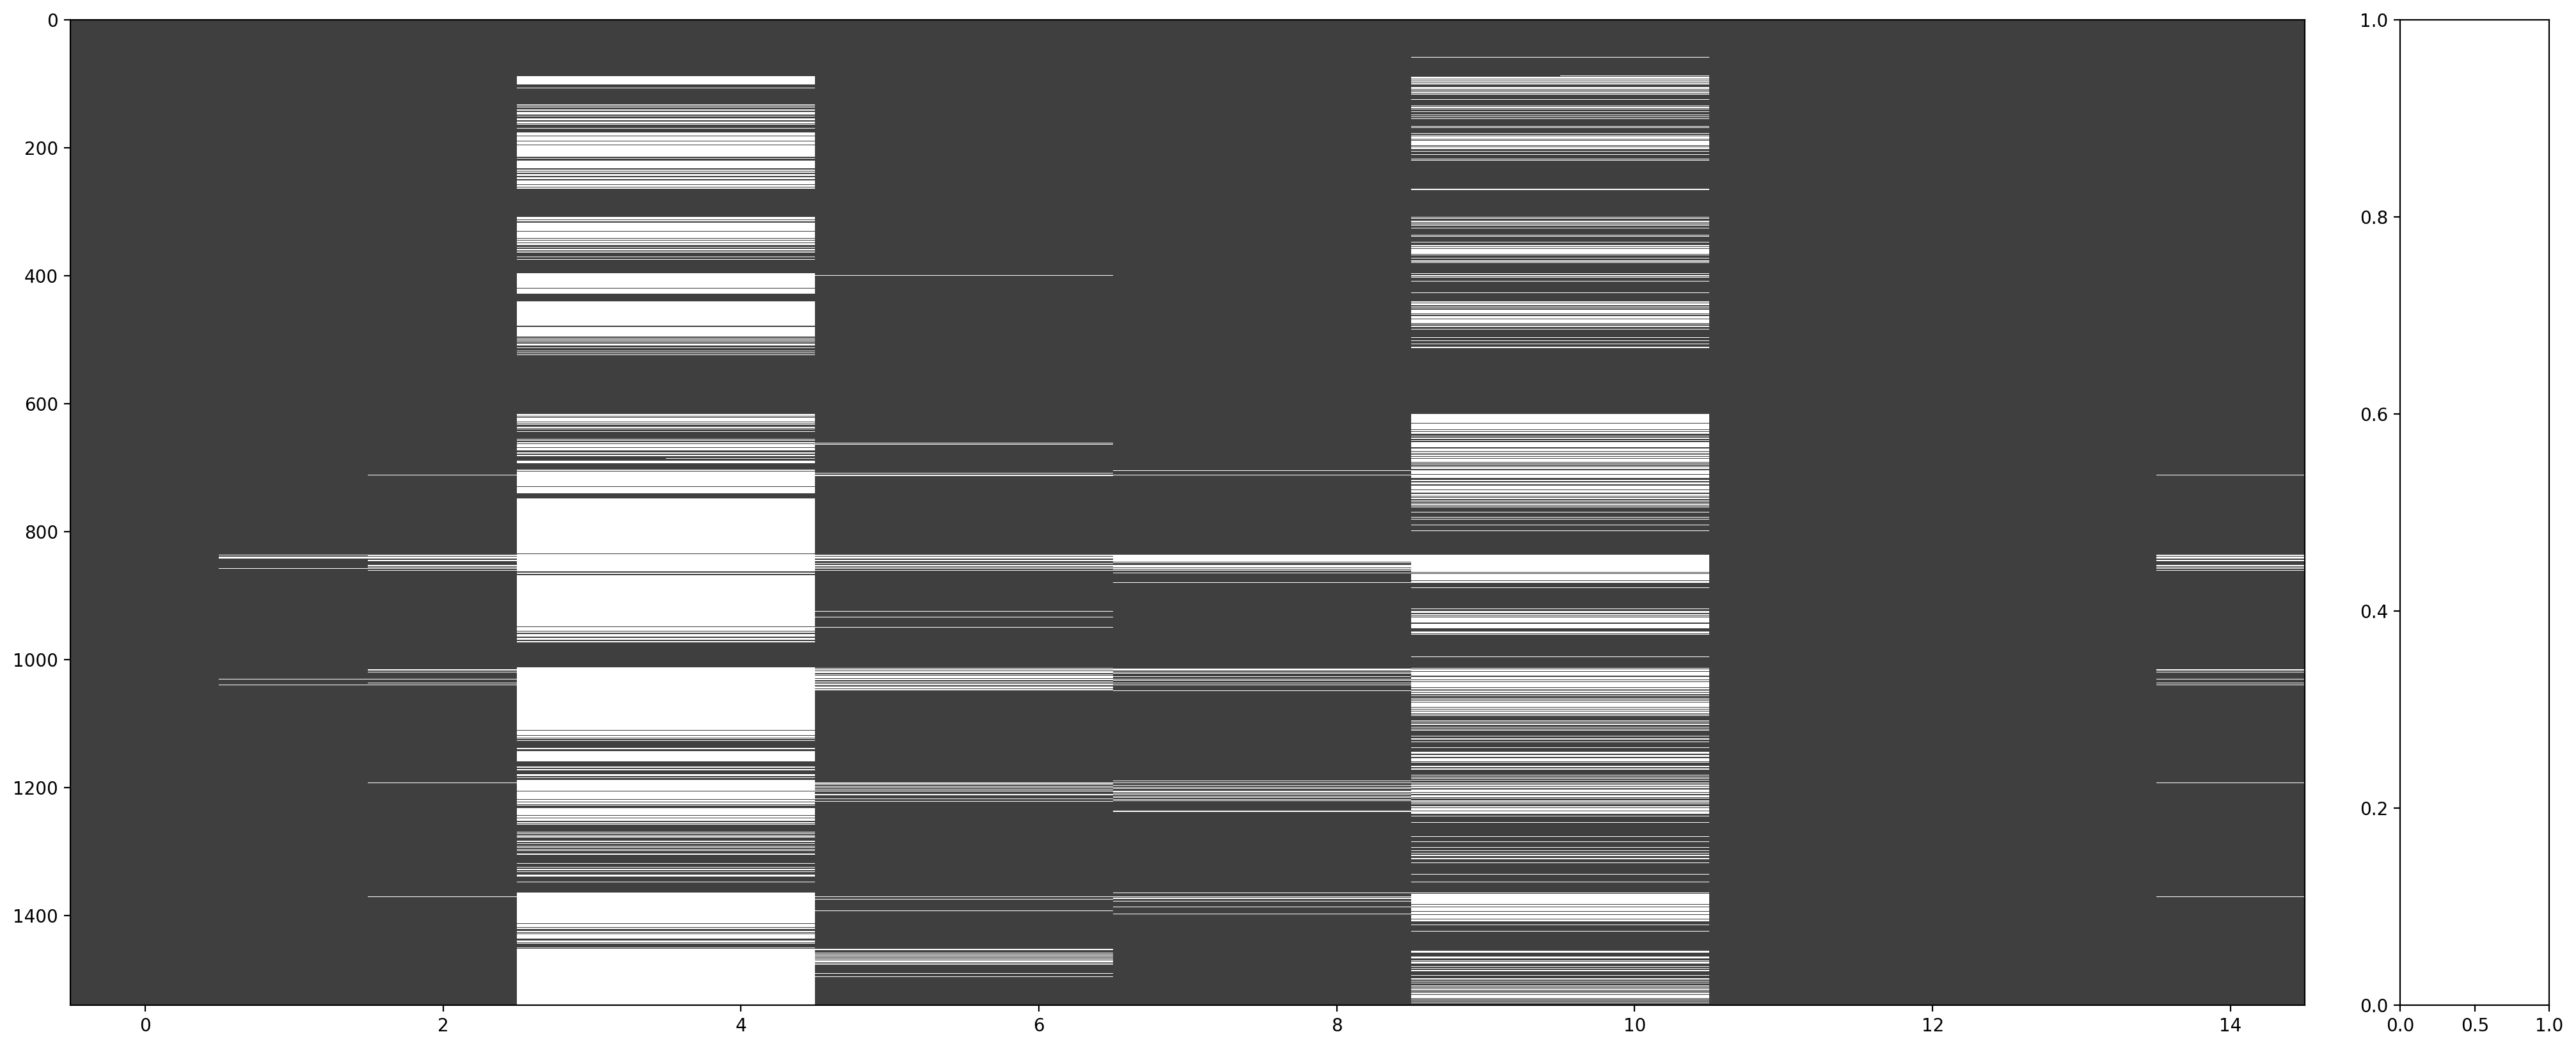

In [520]:
msno.matrix(rent)

In [521]:
print("Percentage of missing data")
(rent.isna().sum(axis=0).sort_values(ascending=False) / rent.shape[0])*100

Percentage of missing data


AvgLeaseRate_Bachelor        58.441558
TotalLeased_Bachelor         58.376623
AvgLeaseRate_ThreeBedroom    32.402597
TotalLeased_ThreeBedroom     32.337662
TotalLeased_OneBedroom        4.740260
                               ...    
Listed_AllApartments          0.454545
district                      0.000000
Year                          0.000000
Quarter                       0.000000
YearQuarter                   0.000000
Length: 15, dtype: float64

# Drop bachelor apartments

In [522]:
# drop Bachelor apartments columns since over 50% of the data is missing
rent.drop(columns=['AvgLeaseRate_Bachelor', 'TotalLeased_Bachelor'], inplace=True)

# Interpolate NA values

In [525]:
# check rows with na
na_index = rent[rent.isna().sum(axis=1) != 0].head(1).index[0]
rent.iloc[(na_index - 1):(na_index + 2)]

district  Listed_AllApartments  Leased_AllApartments   
57      C02                   589                   217  \
58      C02                   626                   343   
59      C02                   374                   141   

    TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom   
57                     122                     1779                      84  \
58                     207                     1975                     115   
59                      70                     1981                      60   

    AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom   
57                     4394                         2  \
58                     3405                      <NA>   
59                     3697                         2   

    AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter   
57                       4900  2015        2      2015Q2  \
58                       <NA>  2015        3      2015Q3   
59                       8750  2015        4      2015Q4   

    LeasedvsListed_AllApartments  
57                      0.368421  
58                      0.547923  
59                      0.377005

In [529]:
# missing data interpolated
pd.DataFrame(rent.iloc[(na_index - 1):(na_index + 2)]).bfill(axis=0)

district  Listed_AllApartments  Leased_AllApartments   
57      C02                   589                   217  \
58      C02                   626                   343   
59      C02                   374                   141   

    TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom   
57                     122                     1779                      84  \
58                     207                     1975                     115   
59                      70                     1981                      60   

    AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom   
57                     4394                         2  \
58                     3405                         2   
59                     3697                         2   

    AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter   
57                       4900  2015        2      2015Q2  \
58                       8750  2015        3      2015Q3   
59                       8750  2015        4      2015Q4   

    LeasedvsListed_AllApartments  
57                      0.368421  
58                      0.547923  
59                      0.377005

In [530]:
# first interpolate within each neighbourhood only
# then assume the first record is NA, we do backward fill within each neighbourhood
for district in rent.district.unique():
    # rent.loc[rent['district'] == district] = rent.loc[rent['district'] == district].ffill(axis=0).bfill(axis=0).values
    rent.loc[rent['district'] == district] = rent.loc[rent['district'] == district].ffill(axis=0).bfill(axis=0).values

In [531]:
print("Percentage of missing data")
(rent.isna().sum(axis=0).sort_values(ascending=False) / rent.shape[0])*100

Percentage of missing data


district                        0.0
Listed_AllApartments            0.0
Leased_AllApartments            0.0
TotalLeased_OneBedroom          0.0
AvgLeaseRate_OneBedroom         0.0
                               ... 
AvgLeaseRate_ThreeBedroom       0.0
Year                            0.0
Quarter                         0.0
YearQuarter                     0.0
LeasedvsListed_AllApartments    0.0
Length: 13, dtype: float64

# Add per-bedroom statistics 

In [532]:
room_types = [re.search("TotalLeased_(\w+)", x).group(1) for x in rent.columns if re.search("TotalLeased_(\w+)", x) is not None]
room_types

['OneBedroom', 'TwoBedroom', 'ThreeBedroom']

In [533]:
# to compare number of leased aparatments and lease rates across different room types
# we must normalize by the number of rooms
for type in room_types:
    
    if type == 'OneBedroom':
        room_num = 1
    elif type == 'TwoBedroom':
        room_num = 2
    elif type == 'ThreeBedroom':
        room_num = 3
    
    # for number of leased apartments, we multiply by the number of bedrooms
    # e.g. 1 listing of 3-bedroom apartment = 3 listings of 1-bedroom apartment
    rent['TotalLeasedPerRoom_' + type] = rent['TotalLeased_' + type] * room_num
    
    # for number of leased apartments, we divide by the number of bedrooms
    # since you split the cost with your roommates
    rent['AvgLeaseRatePerRoom_' + type] = rent['AvgLeaseRate_' + type] / room_num

In [534]:
for agg_type in ['AllApartments', 'SharedApartments']:
    rent['TotalLeased_' + agg_type] = 0
    rent['TotalLeasedPerRoom_' + agg_type] = 0
    rent['AvgLeaseRate_' + agg_type] = 0
    rent['AvgLeaseRatePerRoom_' + agg_type] = 0
    if agg_type == 'AllApartments':
        room_list = room_types
    elif agg_type == 'SharedApartments':
        room_list = ['TwoBedroom', 'ThreeBedroom']
    for room in room_list:
        rent['TotalLeased_' + agg_type] += rent['TotalLeased_' + room]
        rent['AvgLeaseRate_' + agg_type] += rent['AvgLeaseRate_' + room] * rent['TotalLeased_' + room]
        rent['TotalLeasedPerRoom_' + agg_type] += rent['TotalLeasedPerRoom_' + room]
        rent['AvgLeaseRatePerRoom_' + agg_type] += rent['AvgLeaseRatePerRoom_' + room] * rent['TotalLeasedPerRoom_' + room]

    rent['AvgLeaseRate_' + agg_type] = rent['AvgLeaseRate_' + agg_type] / rent['TotalLeased_' + agg_type]
    rent['AvgLeaseRatePerRoom_' + agg_type] = rent['AvgLeaseRatePerRoom_' + agg_type] / rent['TotalLeasedPerRoom_' + agg_type]

In [535]:
rent

district  Listed_AllApartments  Leased_AllApartments   
0         C01                  2038                  1194  \
1         C01                  2160                  1350   
2         C01                  2255                  1408   
3         C01                  1917                  1012   
4         C01                  2845                  1350   
...       ...                   ...                   ...   
1535      W10                    85                    46   
1536      W10                    72                    46   
1537      W10                    59                    44   
1538      W10                    55                    39   
1539      W10                    54                    34   

      TotalLeased_OneBedroom  AvgLeaseRate_OneBedroom  TotalLeased_TwoBedroom   
0                        759                     1666                     370  \
1                        795                     1739                     453   
2                        859                     1802                     476   
3                        647                     1844                     319   
4                        868                     1758                     404   
...                      ...                      ...                     ...   
1535                      19                     1804                      24   
1536                      24                     1907                      22   
1537                      24                     2009                      18   
1538                      24                     2286                      12   
1539                      15                     2324                      13   

      AvgLeaseRate_TwoBedroom  TotalLeased_ThreeBedroom   
0                        2510                         6  \
1                        2603                        24   
2                        2667                        23   
3                        2650                         9   
4                        2578                        16   
...                       ...                       ...   
1535                     2223                         3   
1536                     2337                         3   
1537                     2453                         2   
1538                     2635                         3   
1539                     2682                         6   

      AvgLeaseRate_ThreeBedroom  Year  Quarter YearQuarter   
0                          3194  2012        1      2012Q1  \
1                          4321  2012        2      2012Q2   
2                          3891  2012        3      2012Q3   
3                          3717  2012        4      2012Q4   
4                          4719  2013        1      2013Q1   
...                         ...   ...      ...         ...   
1535                       2483  2021        4      2021Q4   
1536                       2483  2022        1      2022Q1   
1537                       2725  2022        2      2022Q2   
1538                       2617  2022        3      2022Q3   
1539                       2906  2022        4      2022Q4   

      LeasedvsListed_AllApartments  TotalLeasedPerRoom_OneBedroom   
0                         0.585868                            759  \
1                            0.625                            795   
2                          0.62439                            859   
3                         0.527908                            647   
4                         0.474517                            868   
...                            ...                            ...   
1535                      0.541176                             19   
1536                      0.638889                             24   
1537                      0.745763                             24   
1538                      0.709091                             24   
1539                       0.62963                             15   

      AvgLeaseRa

# Output

In [536]:
# specify separator and suffix
rent_output = pd.wide_to_long(
    rent, 
    stubnames=['TotalLeased', 'AvgLeaseRate', 'TotalLeasedPerRoom', 'AvgLeaseRatePerRoom'], 
    i=['district', 'Listed_AllApartments', 'Leased_AllApartments', 'LeasedvsListed_AllApartments', 'Year', 'Quarter', 'YearQuarter'], 
    j='RoomType', 
    sep='_',
    suffix='\w+'
    ).reset_index()

In [537]:
rent_output

district  Listed_AllApartments  Leased_AllApartments   
0         C01                  2038                  1194  \
1         C01                  2038                  1194   
2         C01                  2038                  1194   
3         C01                  2038                  1194   
4         C01                  2038                  1194   
...       ...                   ...                   ...   
7695      W10                    54                    34   
7696      W10                    54                    34   
7697      W10                    54                    34   
7698      W10                    54                    34   
7699      W10                    54                    34   

      LeasedvsListed_AllApartments  Year  Quarter YearQuarter   
0                         0.585868  2012        1      2012Q1  \
1                         0.585868  2012        1      2012Q1   
2                         0.585868  2012        1      2012Q1   
3                         0.585868  2012        1      2012Q1   
4                         0.585868  2012        1      2012Q1   
...                            ...   ...      ...         ...   
7695                       0.62963  2022        4      2022Q4   
7696                       0.62963  2022        4      2022Q4   
7697                       0.62963  2022        4      2022Q4   
7698                       0.62963  2022        4      2022Q4   
7699                       0.62963  2022        4      2022Q4   

              RoomType  TotalLeased  AvgLeaseRate  TotalLeasedPerRoom   
0           OneBedroom          759        1666.0                 759  \
1           TwoBedroom          370        2510.0                 740   
2         ThreeBedroom            6        3194.0                  18   
3        AllApartments         1135   1949.214097                1517   
4     SharedApartments          376   2520.914894                 758   
...                ...          ...           ...                 ...   
7695        OneBedroom           15        2324.0                  15   
7696        TwoBedroom           13        2682.0                  26   
7697      ThreeBedroom            6        2906.0                  18   
7698     AllApartments           34   2563.588235                  59   
7699  SharedApartments           19   2752.736842                  44   

      AvgLeaseRatePerRoom  
0                  1666.0  
1                  1255.0  
2             1064.666667  
3              1458.37706  
4             1250.480211  
...                   ...  
7695               2324.0  
7696               1341.0  
7697           968.666667  
7698          1477.322034  
7699          1188.681818  

[7700 rows x 12 columns]

In [538]:
rent_output.to_csv('../data/processed/rent.csv', index=False)

In [539]:
# trreb_total.to_csv('../data/processed/trreb_total.csv', index=False)

# Improvements
- granularity by postal code, or even by property (idiosyncratic differences do exist within the same neighbourhood)
- Reference for getting data from zumper: https://medium.com/@backupfairuz/exploring-rental-rates-in-canada-hands-on-project-making-use-of-foursquare-api-with-python-413793d2dfca
- HouseSigma listing data

In [ ]:
# Improvement
# bungol.ca for data of housing transaction prices (not listing like other websites)
# real transaction data instead of listings
# access to paid APIs https://rapidapi.com/blog/best-real-estate-apis/